In [89]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm
import numpy as np

# Clustering

In [3]:
#reading in the dataset
df = pd.read_csv("..\\..\\data\\healthcare-dataset-stroke-data.csv") # path must be changed always

In [4]:
#should be handled in the cleaning section of code 
df = df.fillna(df.median())

C:\Users\laise\AppData\Local\Temp/ipykernel_12124/43336777.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df = df.fillna(df.median())


In [5]:
df.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


# Clusters by average glucose level and bmi

Clustering is about discovering groupings within continous variables and partitioning the id into
strategic groups. The best senario is to have clusters with high within-cluster similarity, but are very dissimilar to objects
in other clusters. In this section, we try to cluster relating to health-risk profiles. We assume health risk to occur, when a person has a high level of average glukose level and also a high bmi. 

BMI above 25 is considered overweight  

According to netdoktor.dk the glukose level should variate between 4-8 mmol/l (80-150 mg/dl)

https://www.netdoktor.dk/sunderaad/fakta/diabetesblodsukker.htm

https://netdoktor.dk/interactive/interactivetests/bmi.php

In [6]:
gluc_bmi = df[["avg_glucose_level","bmi"]]
gluc_bmi_stroke = df[["avg_glucose_level","bmi", "stroke"]]

In [7]:
#https://stats.stackexchange.com/questions/89809/is-it-important-to-scale-data-before-clustering
gluc_bmi = MinMaxScaler().fit_transform(gluc_bmi)
gluc_bmi = pd.DataFrame(gluc_bmi,columns=["avg_glucose_level","bmi"])
gluc_bmi.describe().round(2)

,avg_glucose_level,bmi
count,5110.00,5110.00
mean,0.24,0.21
std,0.21,0.09
min,0.00,0.00
25%,0.10,0.15
50%,0.17,0.20
75%,0.27,0.26
max,1.00,1.00


In [8]:
#https://stats.stackexchange.com/questions/89809/is-it-important-to-scale-data-before-clustering
gluc_bmi_stroke = MinMaxScaler().fit_transform(gluc_bmi_stroke)
gluc_bmi_stroke = pd.DataFrame(gluc_bmi_stroke,columns=["avg_glucose_level","bmi", "stroke"])
gluc_bmi_stroke

,avg_glucose_level,bmi,stroke
0,0.801265,0.301260,1.0
1,0.679023,0.203895,1.0
2,0.234512,0.254296,1.0
3,0.536008,0.276060,1.0
4,0.549349,0.156930,1.0
...,...,...,...
5105,0.132167,0.203895,0.0
5106,0.323516,0.340206,0.0
5107,0.128658,0.232532,0.0
5108,0.513203,0.175258,0.0


<AxesSubplot:xlabel='avg_glucose_level', ylabel='bmi'>

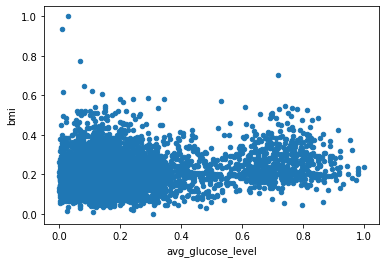

In [9]:
gluc_bmi.plot.scatter("avg_glucose_level","bmi")
#plt.axvline(150, color='k', linestyle='dashed', linewidth=1) #must be converted 
#plt.axhline(25, color='k', linestyle='dashed', linewidth=1) #must be converted 

### Finding the right k in k-means

In order to find the best fitting number of clusters, we evaluate different k's by the elbow and silhuette method

##### The elbow method
Distortion: Calculated as the avg of the squared distances from the cluster centers. Typically, the Euclidean distance metric is used.

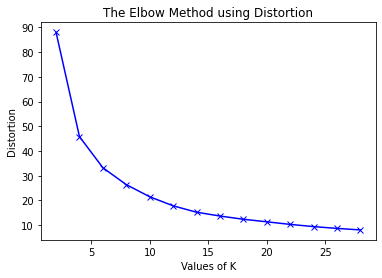

In [10]:
distortions = [] 
                 
K = range(2,30,2)

for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(gluc_bmi)
    kmeanModel.fit(gluc_bmi)
    distortions.append(kmeanModel.inertia_)

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

#### The silhouette method

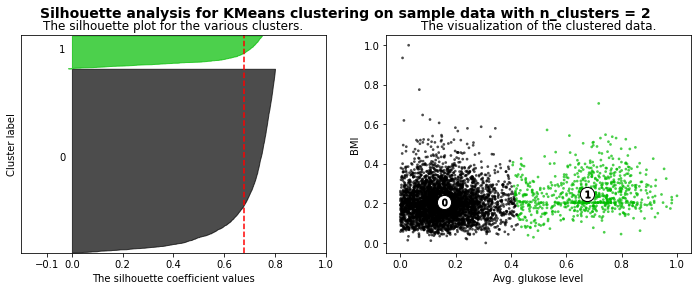

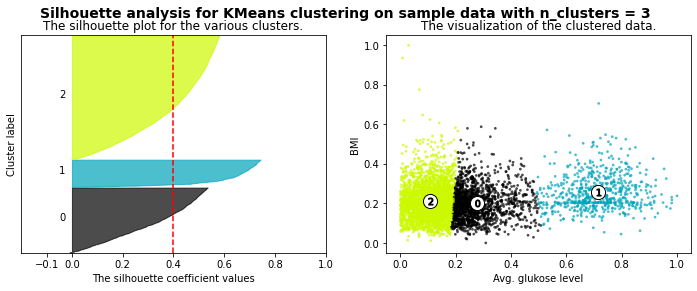

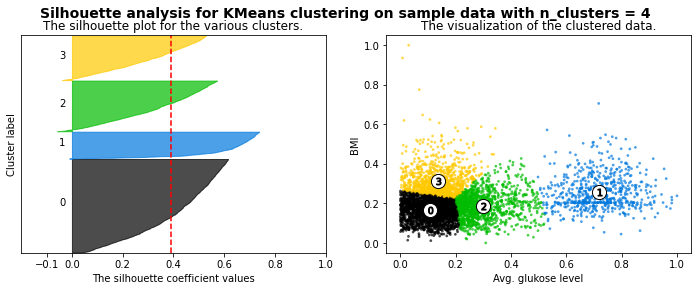

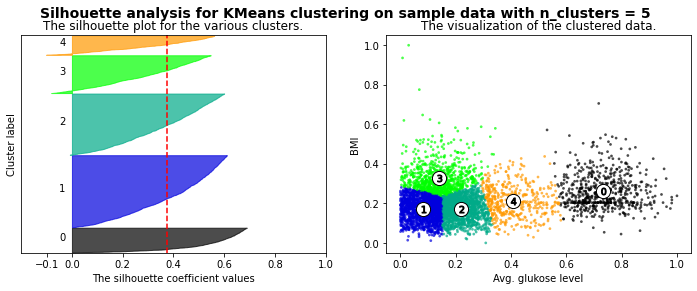

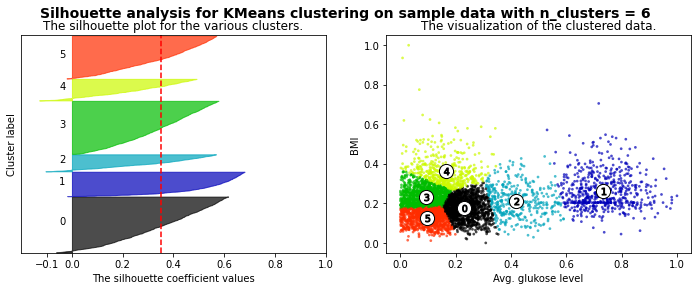

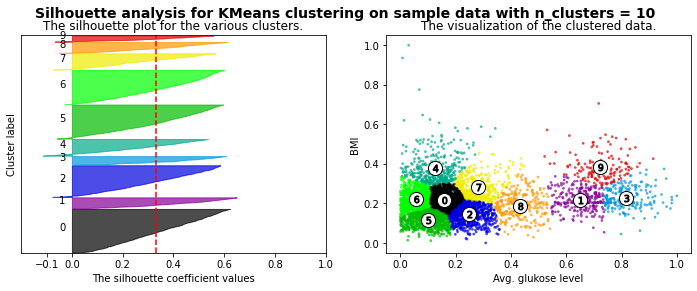

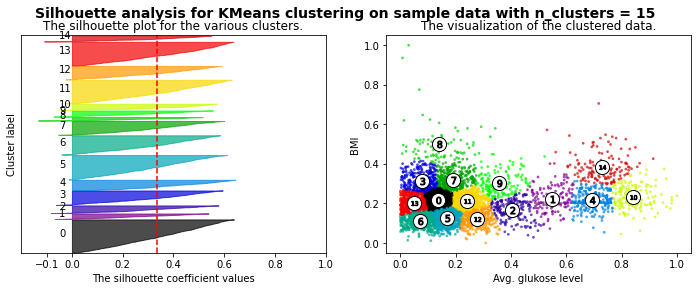

In [11]:
#https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

X = gluc_bmi

range_n_clusters = [2, 3, 4, 5, 6, 10, 15]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(12, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.2, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    #print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg,)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X["avg_glucose_level"], X["bmi"], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Avg. glukose level")
    ax2.set_ylabel("BMI")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

### Viewing the final k-means clusters

must be ajusted when settled on a k

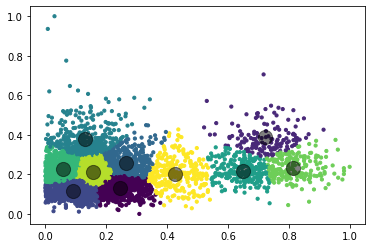

In [12]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(gluc_bmi)
y_kmeans = kmeans.predict(gluc_bmi)

plt.scatter(gluc_bmi["avg_glucose_level"], gluc_bmi["bmi"], c=y_kmeans, s=10, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

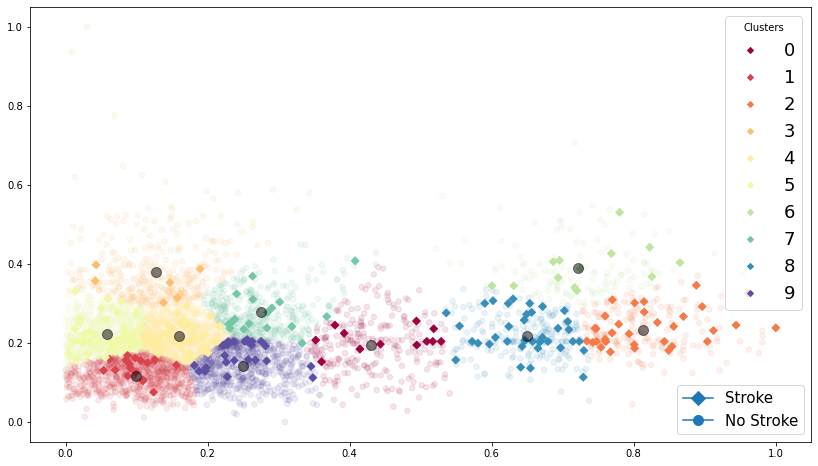

In [13]:
from matplotlib.lines import Line2D

kmeans = KMeans(n_clusters=10)
kmeans.fit(gluc_bmi_stroke[["avg_glucose_level","bmi"]])
y_kmeans = kmeans.predict(gluc_bmi_stroke[["avg_glucose_level","bmi"]])

fig, ax = plt.subplots(figsize=(14,8))

# add clusters to df
gluc_bmi_stroke["cluster"] = y_kmeans
# split df into strokes and non-strokes
non_strokes = gluc_bmi_stroke[gluc_bmi_stroke["stroke"] == 0]
strokes = gluc_bmi_stroke[gluc_bmi_stroke["stroke"] == 1]
# plot non-strokes
ax.scatter(non_strokes["avg_glucose_level"], non_strokes["bmi"], c=non_strokes["cluster"], s=30, marker='o', alpha=0.1, cmap='Spectral')
# and strokes
scatter = ax.scatter(strokes["avg_glucose_level"], strokes["bmi"], c=strokes["cluster"], s=30, marker='D', cmap='Spectral')
centers = kmeans.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5)

# legend for cluster numbers
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Clusters", prop={'size': 18})
ax.add_artist(legend1)
# legend for stroke/no stroke
legend_elements = [Line2D([0], [0], marker='D', label='Stroke', markersize=10),
                   Line2D([0], [0], marker='o', label='No Stroke', markersize=10),
                  ]
legend2 = ax.legend(handles=legend_elements, loc='lower right', prop={'size': 15})
plt.show()

In [14]:
# Calculate percentage of stroke cases for each cluster
total_strokes = strokes.shape[0]

for cluster in np.unique(y_kmeans):
    stroke_cases_cluster = strokes[strokes["cluster"] == cluster].shape[0]
    non_stroke_cases_cluster = non_strokes[non_strokes["cluster"] == cluster].shape[0]
    cluster_ratio = stroke_cases_cluster/(stroke_cases_cluster+non_stroke_cases_cluster)
    overall_stroke_percent = stroke_cases_cluster/total_strokes
    print(f"There are {cluster_ratio:.2%} stroke cases in cluster {cluster}, which corresponds to {overall_stroke_percent:.2%} of all strokes")


There are 4.46% stroke cases in cluster 0, which corresponds to 4.82% of all strokes
There are 2.10% stroke cases in cluster 1, which corresponds to 6.83% of all strokes
There are 14.80% stroke cases in cluster 2, which corresponds to 13.25% of all strokes
There are 1.51% stroke cases in cluster 3, which corresponds to 2.41% of all strokes
There are 4.21% stroke cases in cluster 4, which corresponds to 17.67% of all strokes
There are 5.42% stroke cases in cluster 5, which corresponds to 18.07% of all strokes
There are 9.85% stroke cases in cluster 6, which corresponds to 5.22% of all strokes
There are 4.21% stroke cases in cluster 7, which corresponds to 6.83% of all strokes
There are 14.07% stroke cases in cluster 8, which corresponds to 14.86% of all strokes
There are 3.38% stroke cases in cluster 9, which corresponds to 10.04% of all strokes


# K-Means Clustering with multiple dimensions

Chose the features: age, avg_glucose_level, heart_disease and hypertension, becuase they have the highest correlation with stroke

## Issues to consider

It is problematic to apply K-means to categorical data, as it is based on numerical distances, so it could consider close two really distant objects that merely have been assigned two close numbers. In this case, we have two binary features (heart disease and hypertension). 

I think that since we scale all features between 0-1, k-means will work still and produce relatively good results. For instance, the difference between HAVING a heart disease (1) and NOT having one (0) can also be measured by the distance metric used by k-means (euclidean distance). However, I think this implies that the features heart dieases and hypertension will be overemphasized compared to glucose level and age, since there are more cases where the binary values have the highest value (1) compared to the numerical features that have been scaled.. hope my thoughts make sense :D

In [57]:
data = df[["age", "avg_glucose_level", "heart_disease", "hypertension", "stroke"]]
data = MinMaxScaler().fit_transform(data)
data = pd.DataFrame(data,columns=["age", "avg_glucose_level", "heart_disease", "hypertension", "stroke"])
data

,age,avg_glucose_level,heart_disease,hypertension,stroke
0,0.816895,0.801265,1.0,0.0,1.0
1,0.743652,0.679023,0.0,0.0,1.0
2,0.975586,0.234512,1.0,0.0,1.0
3,0.597168,0.536008,0.0,0.0,1.0
4,0.963379,0.549349,0.0,1.0,1.0
...,...,...,...,...,...
5105,0.975586,0.132167,0.0,1.0,0.0
5106,0.987793,0.323516,0.0,0.0,0.0
5107,0.426270,0.128658,0.0,0.0,0.0
5108,0.621582,0.513203,0.0,0.0,0.0


In [16]:
# Techniques to determine cluster sizes are missing!

# @Naja could you add that here? :)


In [69]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(data[["age", "avg_glucose_level", "heart_disease", "hypertension"]])
y_kmeans = kmeans.predict(data[["age", "avg_glucose_level", "heart_disease", "hypertension"]])
data["cluster"] = y_kmeans

# split into stroke and non stroke cases
non_strokes = data[data["stroke"] == 0]
strokes = data[data["stroke"] == 1]

In [75]:
data[data["cluster"] == 2]

,age,avg_glucose_level,heart_disease,hypertension,stroke,cluster
4,0.963379,0.549349,0.0,1.0,1.0,2
10,0.987793,0.116841,0.0,1.0,1.0,2
15,0.609375,0.518373,0.0,1.0,1.0,2
17,0.914551,0.767104,0.0,1.0,1.0,2
21,0.633789,0.822500,0.0,1.0,1.0,2
...,...,...,...,...,...,...
5088,0.780273,0.100499,0.0,1.0,0.0,2
5091,0.719238,0.184332,0.0,1.0,0.0,2
5093,0.548340,0.184194,0.0,1.0,0.0,2
5100,1.000000,0.077786,0.0,1.0,0.0,2


In [70]:
# Calculate percentage of stroke cases for each cluster
total_strokes = strokes.shape[0]

for cluster in np.unique(y_kmeans):
    stroke_cases_cluster = strokes[strokes["cluster"] == cluster].shape[0]
    non_stroke_cases_cluster = non_strokes[non_strokes["cluster"] == cluster].shape[0]
    cluster_ratio = stroke_cases_cluster/(stroke_cases_cluster+non_stroke_cases_cluster)
    overall_stroke_percent = stroke_cases_cluster/total_strokes
    print(f"Cluster {cluster} - Ratio of stroke cases within cluster: {cluster_ratio:.2%} - Corresponds to {overall_stroke_percent:.2%} of all strokes")

Cluster 0 - Ratio of stroke cases within cluster: 16.04% - Corresponds to 13.65% of all strokes
Cluster 1 - Ratio of stroke cases within cluster: 0.15% - Corresponds to 1.20% of all strokes
Cluster 2 - Ratio of stroke cases within cluster: 12.21% - Corresponds to 21.29% of all strokes
Cluster 3 - Ratio of stroke cases within cluster: 5.20% - Corresponds to 41.77% of all strokes
Cluster 4 - Ratio of stroke cases within cluster: 20.31% - Corresponds to 5.22% of all strokes
Cluster 5 - Ratio of stroke cases within cluster: 9.50% - Corresponds to 16.87% of all strokes


In [19]:
'''
The results are quite interesting. 
- One cluster has high ratio of stroke cases in it's data points (17%), interestingly this cluster contains ONLY cases of people 
  who have a heart disease and some who have hypertension
- Another cluster with ratio of stroke cases of 12 % has 21 % of all stroke cases and contains ONLY people who have hypertension
'''

"\nThe results are quite interesting. \n- One cluster has high ratio of stroke cases in it's data points (17%), interestingly this cluster contains ONLY cases of people \n  who have a heart disease and some who have hypertension\n- Another cluster with ratio of stroke cases of 12 % has 21 % of all stroke cases and contains ONLY people who have hypertension\n"

In [82]:
from sklearn.decomposition import PCA

# Create a PCA model to reduce our data to 2 dimensions for visualisation
pca = PCA(n_components=3)
pca.fit(data[["age", "avg_glucose_level", "heart_disease", "hypertension"]])
# Transfor the scaled data to the new PCA space
X_reduced = pca.transform(data[["age", "avg_glucose_level", "heart_disease", "hypertension"]])
# Convert to df
X_reduceddf = pd.DataFrame(X_reduced, index=X.index, columns=['PC1','PC2', 'PC3'])
# # Add clusters and strokes
X_reduceddf["cluster"] = y_kmeans
X_reduceddf["stroke"] = data["stroke"]

In [83]:
# would also be nice to show the cluster centres, but we need to apply the same PCA transformation that we gave to the actual data points, so that they can appear in the new 2 dimensional PCA space
centres_reduced = pca.transform(kmeans.cluster_centers_)

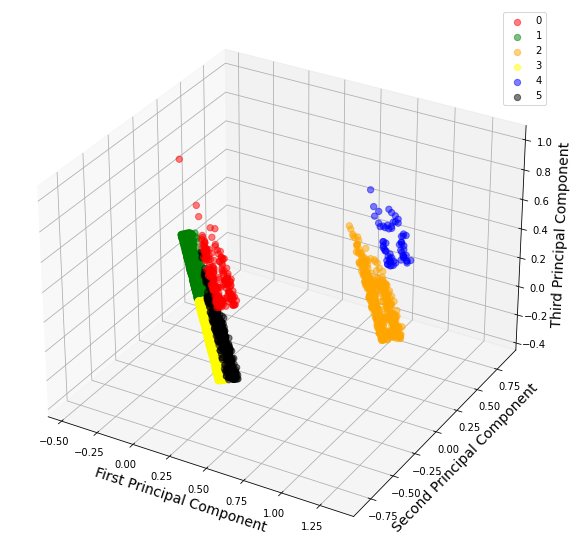

In [84]:
# 3D
ex_variance=np.var(X_reduced,axis=0)
ex_variance_ratio = ex_variance/np.sum(ex_variance)
ex_variance_ratio

Xax = X_reduced[:,0]
Yax = X_reduced[:,1]
Zax = X_reduced[:,2]

cdict = {0:'red',1:'green', 2:"orange", 3:"yellow", 4:"blue", 5:"black"}
labl = {0:'0',1:'1', 2:"2",3:"3", 4:"4", 5:"5"}
marker = {0:'o',1:'o', 2:'o', 3:"o", 4:"o", 5:"o"}
alpha = {0:.5, 1:.5, 2:.5, 3:.5, 4:.5, 5:.5}

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection='3d')

fig.patch.set_facecolor('white')
for l in np.unique(y_kmeans):
 ix=np.where(y_kmeans==l)
 ax.scatter(Xax[ix], Yax[ix], Zax[ix], c=cdict[l], s=40,
           label=labl[l], marker=marker[l], alpha=alpha[l])
# for loop ends
ax.set_xlabel("First Principal Component", fontsize=14)
ax.set_ylabel("Second Principal Component", fontsize=14)
ax.set_zlabel("Third Principal Component", fontsize=14)

ax.legend()
plt.show()


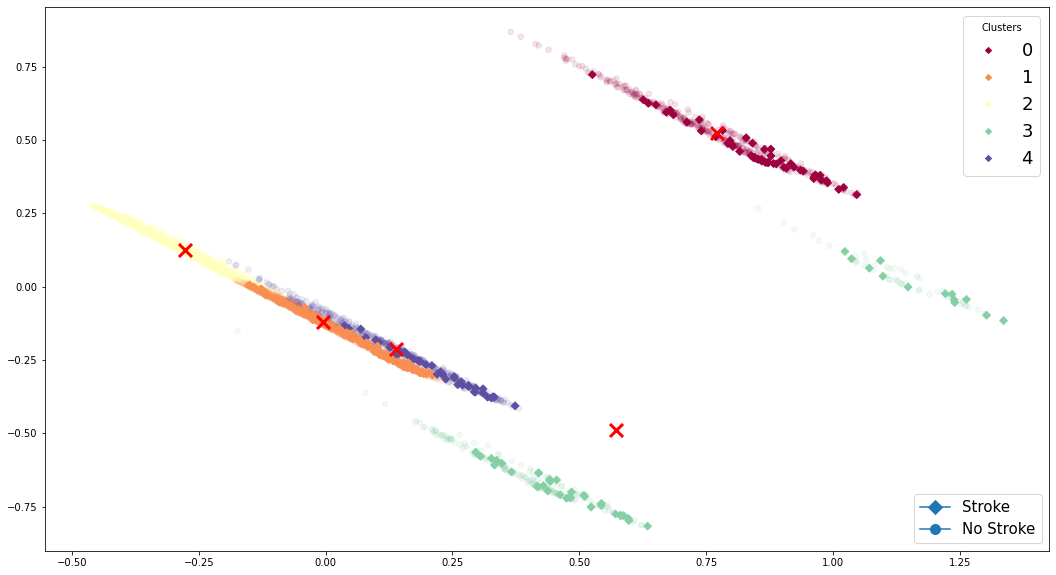

In [40]:
# Plot the results (Only works for 2 dimensions)

fig, ax = plt.subplots(figsize=(18,10))

non_strokes = X_reduceddf[X_reduceddf["stroke"] == 0]
strokes = X_reduceddf[X_reduceddf["stroke"] == 1]

# plot non-strokes
ax.scatter(non_strokes["PC1"], non_strokes["PC2"], c=non_strokes["cluster"], s=30, marker='o', alpha=0.1, cmap='Spectral')
# and strokes
scatter = ax.scatter(strokes["PC1"], strokes["PC2"], c=strokes["cluster"], s=30, marker='D', cmap='Spectral')
# plot cluster centers
ax.scatter(centres_reduced[:, 0], centres_reduced[:, 1],
            marker='x', s=169, linewidths=3,
            color='r', zorder=10)
# legend for cluster numbers
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Clusters", prop={'size': 18})
ax.add_artist(legend1)
# legend for stroke/no stroke
legend_elements = [Line2D([0], [0], marker='D', label='Stroke', markersize=10),
                   Line2D([0], [0], marker='o', label='No Stroke', markersize=10),
                  ]
legend2 = ax.legend(handles=legend_elements, loc='lower right', prop={'size': 15})
plt.show()

0.8534842514507617

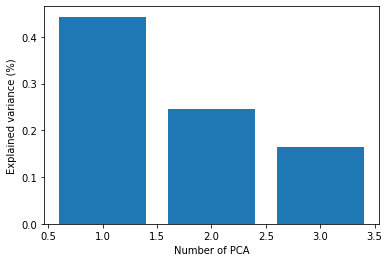

In [85]:
variance = pca.explained_variance_ratio_
fig, ax = plt.subplots()
ax.bar(range(1,4), variance)
ax.set_ylabel("Explained variance (%)")
ax.set_xlabel("Number of PCA")

sum(variance)

Text(0.5, 0.98, 'Importance of features for first PCA')

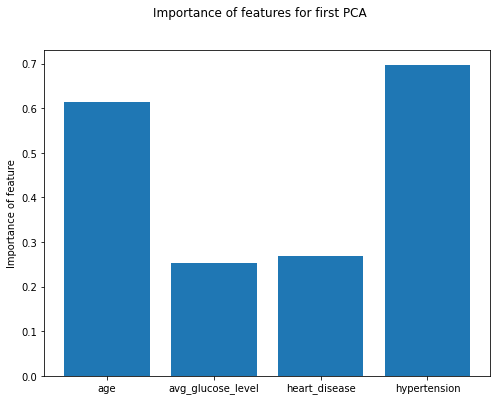

In [86]:
abs(pca.components_)
first_component = abs(pca.components_[0])

x = ["age", "avg_glucose_level", "heart_disease", "hypertension"]
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x, first_component)
ax.set_ylabel("Importance of feature") # -> components of eigenvectors
fig.suptitle("Importance of features for first PCA")

Text(0.5, 0.98, 'Importance of features for second PCA')

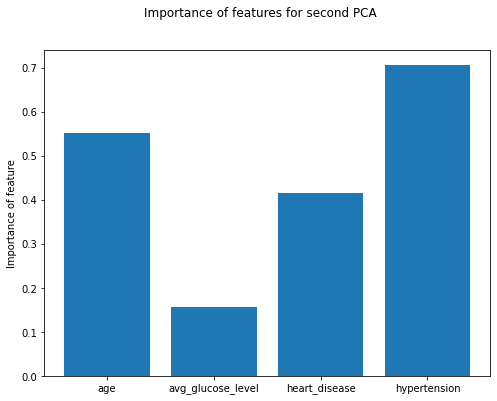

In [87]:
abs(pca.components_)
first_component = abs(pca.components_[1])

x = ["age", "avg_glucose_level", "heart_disease", "hypertension"]
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x, first_component)
ax.set_ylabel("Importance of feature") # -> components of eigenvectors
fig.suptitle("Importance of features for second PCA")

Text(0.5, 0.98, 'Importance of features for third PCA')

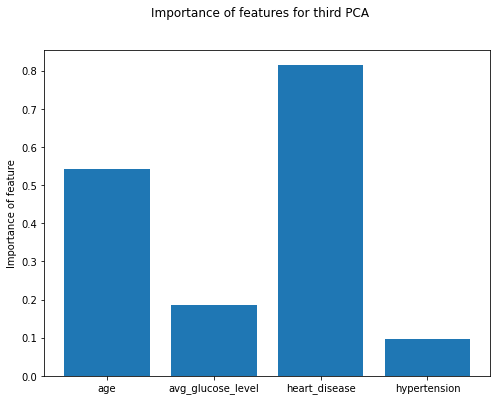

In [88]:
abs(pca.components_)
first_component = abs(pca.components_[2])

x = ["age", "avg_glucose_level", "heart_disease", "hypertension"]
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x, first_component)
ax.set_ylabel("Importance of feature") # -> components of eigenvectors
fig.suptitle("Importance of features for third PCA")